In [15]:
# =========================
# FET312 - SKU110K MobileNetV3 (BBox Regression Demo)
# =========================
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # OMP Error #15 workaround (Windows)

import random
import sys
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm


In [16]:
# -------------------------
# AYARLAR
# -------------------------
SEED = 42
EPOCHS = 2          #  2 epoch
BATCH_SIZE = 16
LR = 1e-3
IMG_SIZE = 224
NUM_WORKERS = 0     # Windows için 0 daha stabil

# Notebook üzerinde olduğumuz için Path(__file__) yerine Path.cwd() kullanıyoruz.
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / "dataset"
IMG_DIR = DATA_DIR / "images"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [17]:
# -------------------------
# DATASET (Dummy bbox)
# -------------------------
class SKUDummyBBoxDataset(Dataset):
    """
    Etiket dosyası yoksa pipeline göstermek için dummy bbox üretir.
    bbox format: [x1,y1,x2,y2] (0..1 normalize)
    """
    def __init__(self, img_dir: Path, img_list, transform=None):
        self.img_dir = Path(img_dir)
        self.img_list = list(img_list)
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        fname = self.img_list[idx]
        path = self.img_dir / fname

        # bozuk resim olursa bir sonrakine kay
        try:
            img = Image.open(path).convert("RGB")
        except Exception:
            return self.__getitem__((idx + 1) % len(self.img_list))

        if self.transform:
            img = self.transform(img)

        # Dummy bbox (merkezde)
        box = torch.tensor([0.20, 0.20, 0.80, 0.80], dtype=torch.float32)
        return img, box


In [18]:
# -------------------------
# MODEL (MobileNetV3 backbone + reg head)
# -------------------------
class MobileNetV3BBox(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

        # classifier kısmını at, feature extractor kullan
        self.features = backbone.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # MobileNetV3-small son kanal sayısı (576)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(576, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Sigmoid()  # 0..1 bbox normalize
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.head(x)
        return x


In [19]:
# -------------------------
# TRAIN / EVAL
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    for imgs, targets in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        total += loss.item()
    return total / max(1, len(loader))


@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total = 0.0
    for imgs, targets in tqdm(loader, desc="Val", leave=False):
        imgs = imgs.to(DEVICE)
        targets = targets.to(DEVICE)

        preds = model(imgs)
        loss = criterion(preds, targets)
        total += loss.item()
    return total / max(1, len(loader))


In [20]:
# -------------------------
# GÖRSELLEŞTİRME
# -------------------------
def denorm_box_to_pixels(box01, w, h):
    x1 = float(box01[0]) * w
    y1 = float(box01[1]) * h
    x2 = float(box01[2]) * w
    y2 = float(box01[3]) * h
    # güvenlik: x2>x1, y2>y1
    x1, x2 = sorted([x1, x2])
    y1, y2 = sorted([y1, y2])
    return x1, y1, x2, y2


@torch.no_grad()
def save_prediction_examples(model, img_dir: Path, img_list, out_prefix="pred", n=2):
    model.eval()
    transform_vis = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])

    pick = img_list[:n] if len(img_list) >= n else img_list
    for i, fname in enumerate(pick, start=1):
        path = img_dir / fname
        img_pil = Image.open(path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        x = transform_vis(img_pil).unsqueeze(0).to(DEVICE)

        pred = model(x)[0].cpu()

        # çizim
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(img_pil)
        w, h = IMG_SIZE, IMG_SIZE

        # pred bbox (kırmızı)
        px1, py1, px2, py2 = denorm_box_to_pixels(pred, w, h)
        rect_pred = patches.Rectangle((px1, py1), px2 - px1, py2 - py1,
                                      fill=False, linewidth=2)
        ax.add_patch(rect_pred)
        ax.set_title(f"Prediction (red) - {fname}")
        ax.axis("off")

        save_path = PROJECT_DIR / f"{out_prefix}_{i}.png"
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        plt.show()
        plt.close(fig)


def save_loss_plot(train_losses, val_losses, out_path: Path):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()
    plt.close(fig)


def write_one_page_report(best_val, train_losses, val_losses):
    report = f"""
MODEL VE EĞİTİM ÖZETİ (1 Sayfa)

1) Model
- Mimari: MobileNetV3-Small (pretrained) backbone + bbox regression head
- Çıkış: 4 değer (x1, y1, x2, y2) [0..1] aralığında normalize (Sigmoid)

2) Veri ve Ön-İşleme
- Girdi boyutu: {IMG_SIZE}x{IMG_SIZE}
- Dönüşümler: Resize -> ToTensor
- Not: Bu sürümde etiket (bbox) dosyası bağlanmadıysa, eğitim pipeline’ını göstermek için
  dummy bbox kullanılır. (Gerçek detection performansı ölçümü için SKU110K annotation bağlanmalıdır.)

3) Eğitim Ayarları
- Epoch: {EPOCHS}
- Batch size: {BATCH_SIZE}
- Optimizer: Adam (lr={LR})
- Kayıp fonksiyonu: SmoothL1Loss (bbox regression için uygun)
- Donanım: {DEVICE}

4) Sonuçlar
- Best Val Loss: {best_val:.6e}
- Train Loss (epoch bazında): {train_losses}
- Val   Loss (epoch bazında): {val_losses}

5) Çıktılar
- best_model.pth: En iyi val loss’a göre kaydedilen model
- loss.png: Train/Val loss grafiği
- pred_1.png, pred_2.png: Örnek tahmin görselleri
"""
    out = PROJECT_DIR / "MODEL_EGITIM_OZET.txt"
    out.write_text(report.strip(), encoding="utf-8")
    print("Rapor özeti kaydedildi: MODEL_EGITIM_OZET.txt")


Project: c:\Users\Hp\Desktop\Sıla_Özbey_23040301110_DeepDive5
DATA_DIR: c:\Users\Hp\Desktop\Sıla_Özbey_23040301110_DeepDive5\dataset
IMG_DIR : c:\Users\Hp\Desktop\Sıla_Özbey_23040301110_DeepDive5\dataset\images
Device : cpu
Train imgs (raw): 8219
Test  imgs      : 2936
Final Train: 7398
Final Val  : 821
Final Test : 2936

Model hazır. Eğitim başlıyor...



Train:   0%|          | 0/463 [00:00<?, ?it/s]

Val:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1/2 | Train Loss: 0.00030 | Val Loss: 0.00001


Train:   0%|          | 0/463 [00:00<?, ?it/s]

Val:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2/2 | Train Loss: 0.00001 | Val Loss: 0.00000

Eğitim bitti ✅
Best Val Loss: 3.8114038847407546e-06
Kayıt: c:\Users\Hp\Desktop\Sıla_Özbey_23040301110_DeepDive5\best_model.pth


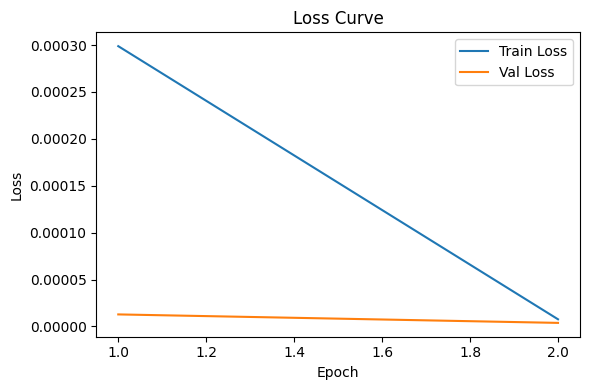

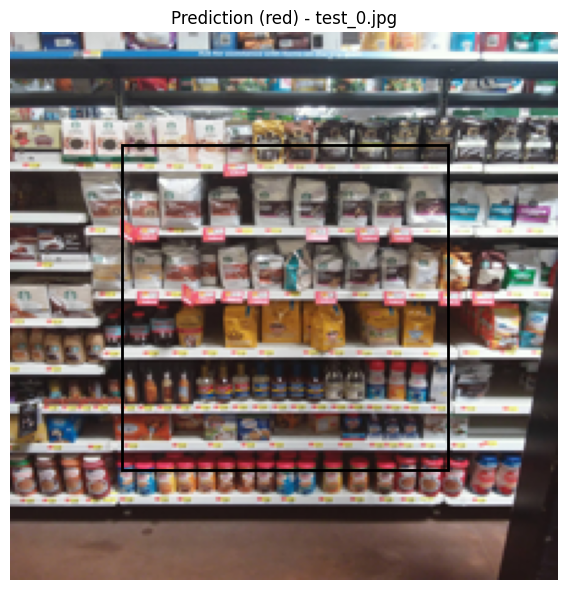

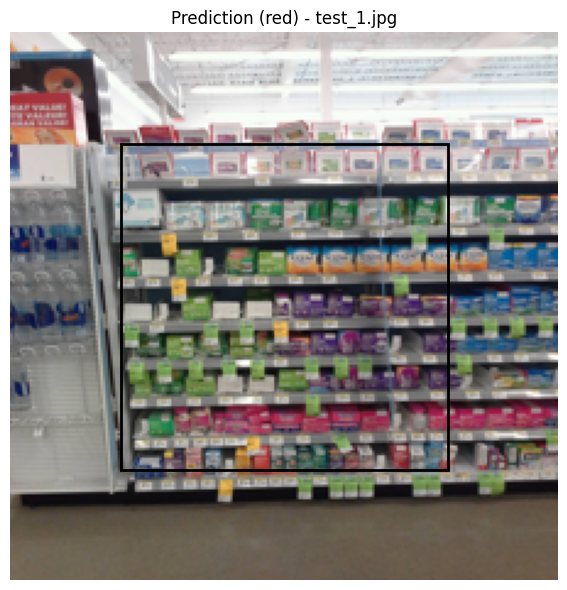

Rapor özeti kaydedildi: MODEL_EGITIM_OZET.txt


In [21]:
seed_everything(SEED)

print("Project:", PROJECT_DIR)
print("DATA_DIR:", DATA_DIR)
print("IMG_DIR :", IMG_DIR)
print("Device :", DEVICE)

if not IMG_DIR.exists():
    print("\nHATA: dataset/images klasörü yok.")
    print("Beklenen yol:", IMG_DIR)
else:
    # resimleri listele
    files = sorted([f.name for f in IMG_DIR.iterdir() if f.suffix.lower() in [".jpg", ".jpeg", ".png"]])
    if len(files) == 0:
        print("\nHATA: dataset/images içinde resim yok.")
    else:
        # test_ ile başlayanları test say, train_ gibi olanları train say
        train_imgs = [f for f in files if f.lower().startswith("train_")]
        test_imgs  = [f for f in files if f.lower().startswith("test_")]

        # Eğer isimlendirme yoksa: hepsini train'e al, küçük kısmı test yap
        if len(train_imgs) == 0 and len(test_imgs) == 0:
            print("Uyarı: train_/test_ isimlendirme yok. Otomatik split yapılacak.")
            random.shuffle(files)
            split = int(0.8 * len(files))
            train_imgs = files[:split]
            test_imgs = files[split:]

        # val split (train'in %10'u)
        random.shuffle(train_imgs)
        val_size = max(1, int(0.1 * len(train_imgs)))
        val_imgs = train_imgs[:val_size]
        train_imgs = train_imgs[val_size:]

        print("Train imgs (raw):", len(train_imgs) + len(val_imgs))
        print("Test  imgs      :", len(test_imgs))
        print("Final Train:", len(train_imgs))
        print("Final Val  :", len(val_imgs))
        print("Final Test :", len(test_imgs))

        # transforms
        transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor()
        ])

        # datasets
        train_ds = SKUDummyBBoxDataset(IMG_DIR, train_imgs, transform=transform)
        val_ds   = SKUDummyBBoxDataset(IMG_DIR, val_imgs, transform=transform)
        test_ds  = SKUDummyBBoxDataset(IMG_DIR, test_imgs, transform=transform)

        # loaders
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

        # model
        model = MobileNetV3BBox().to(DEVICE)

        # train setup
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        criterion = nn.SmoothL1Loss()

        print("\nModel hazır. Eğitim başlıyor...\n")

        train_losses = []
        val_losses = []
        best_val = float("inf")
        best_path = PROJECT_DIR / "best_model.pth"

        for epoch in range(1, EPOCHS + 1):
            tr = train_one_epoch(model, train_loader, optimizer, criterion)
            va = eval_one_epoch(model, val_loader, criterion)

            train_losses.append(float(tr))
            val_losses.append(float(va))

            print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {tr:.5f} | Val Loss: {va:.5f}")

            if va < best_val:
                best_val = va
                torch.save(model.state_dict(), best_path)

        print("\nEğitim bitti ✅")
        print("Best Val Loss:", best_val)
        print("Kayıt:", str(best_path))

        # grafikleri kaydet
        loss_png = PROJECT_DIR / "loss.png"
        save_loss_plot(train_losses, val_losses, loss_png)

        # örnek tahmin görselleri
        if best_path.exists():
            model.load_state_dict(torch.load(best_path, map_location=DEVICE))
            save_prediction_examples(model, IMG_DIR, test_imgs if len(test_imgs) else val_imgs, out_prefix="pred", n=2)

        # rapor dosyası
        write_one_page_report(best_val, train_losses, val_losses)
